<font color = blue><font size = 6> 실험설명 </font></font><br>
Table 작성을 위해서 Window 를 겹쳐서 이동시켰을때 DLinear(+Linearaddition+Scaling)의 성능을 측정해보겠다<br>
여기서는 MultiplicationScaling을 사용하겠다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

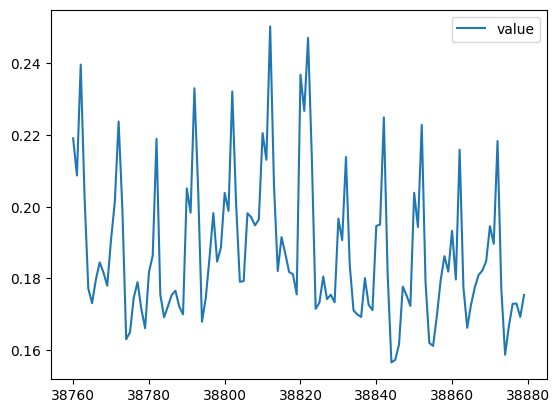

In [4]:
data[-120:].plot()

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment3/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25  
        ###원래 kernel size가 25 이던걸 5로 줄여봤음-> 불규칙한데이터에 대해서 kernel의 영향을 확인하기 위해###
        
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_584931/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 13.292274418455815 %
smape 10.977176817798476 %
smape 10.606913075548166 %
smape 10.78692264854908 %
smape 10.948310513593997 %
smape 11.257206933104504 %
smape 12.344660890119814 %
smape 13.477631725414454 %
smape 12.55277418558709 %
smape 12.479314682515044 %
smape 11.942722601325888 %
smape 11.364296612422368 %
smape 10.604225214984682 %
smape 9.805958928071965 %
smape 9.367598684297668 %
smape 9.483481545807324 %
smape 10.23273870043936 %
smape 10.88938947135245 %
smape 11.472917710654219 %
smape 10.350263356203921 %
smape 9.774510548477284 %
smape 10.217641455213926 %
smape 10.355799324941216 %
smape 9.41328274619858 %
smape 9.301636253881176 %
smape 9.343084760053813 %
smape 9.408039022345989 %
smape 9.588701173401716 %
smape 9.535151568856854 %
smape 9.620918839821341 %
smape 9.875179423313392 %
smape 9.8049387788912 %
smape 10.003958142291733 %
smape 10.038489417897331 %
smape 9.527557297059667 %
smape 9.280002178155888 %
smape 9.424664133299164 %
smape 9.34207458855116 %

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.6826967958809291 %
SMAPE 2.9385257957255817 %
SMAPE 0.9700525004882365 %
SMAPE 1.2741280350019224 %
SMAPE 0.2823015605990804 %
SMAPE 0.27010574211726635 %
SMAPE 1.2505936278521403 %
SMAPE 0.30486330270650797 %
SMAPE 0.19119575486911344 %
SMAPE 0.9715219193021768 %
SMAPE 0.19444553344419546 %
SMAPE 1.7060261377846473 %
SMAPE 0.29326975099434094 %
SMAPE 0.8097442655634951 %
SMAPE 1.2646346568872104 %
SMAPE 1.8044791873835495 %
SMAPE 0.6822718977891782 %
SMAPE 1.2791718601656612 %
SMAPE 0.3325775725297717 %
SMAPE 0.6851194099945133 %
SMAPE 1.6924982644886768 %
SMAPE 1.5700868630069635 %
SMAPE 0.634892717146613 %
SMAPE 0.263490470705392 %
SMAPE 0.3735512679813837 %
SMAPE 2.430309893687081 %
SMAPE 1.3169335869388306 %
SMAPE 0.4759811802177865 %
SMAPE 0.4137946861301316 %
SMAPE 0.27398589131735207 %
SMAPE 0.33243324983732236 %
SMAPE 1.6842092847368804 %
SMAPE 0.4175444999455067 %
SMAPE 0.2661495524912425 %
SMAPE 0.39594582373047155 %
SMAPE 0.8391550502874452 %
SMAPE 0.905430529761361

SMAPE 1.0782146619440027 %
SMAPE 0.20592049554397818 %
SMAPE 0.7561257229244802 %
SMAPE 0.44736441435088636 %
SMAPE 2.1697987516490684 %
SMAPE 0.6156842505988607 %
SMAPE 0.8006112270668381 %
SMAPE 0.4190166977050467 %
SMAPE 0.18697975363465957 %
SMAPE 0.36955244340060744 %
SMAPE 0.4863980847421772 %
SMAPE 0.3275776553500691 %
SMAPE 0.5612350406699989 %
SMAPE 5.579402191660847 %
SMAPE 4.249703928886447 %
SMAPE 0.6783971918484895 %
SMAPE 1.309541668933889 %
SMAPE 0.0997876289798114 %
SMAPE 0.4208995639492059 %
SMAPE 0.21276071939985286 %
SMAPE 0.1855897899313277 %
SMAPE 0.26167252203595126 %
SMAPE 0.1987531941394991 %
SMAPE 0.07914598114678029 %
SMAPE 0.13066723008523695 %
SMAPE 0.4809367873313022 %
SMAPE 1.0034298383361602 %
SMAPE 1.2760075184633024 %
SMAPE 0.265735110490823 %
SMAPE 0.25024845612279023 %
SMAPE 1.813641555214417 %
SMAPE 0.1524577832014984 %
SMAPE 0.3147654621716356 %
SMAPE 0.15290396661475825 %
SMAPE 0.17265566506284813 %
SMAPE 0.4698919677975937 %
SMAPE 0.27025870939951

SMAPE 0.6388905903295381 %
SMAPE 0.142677378924418 %
SMAPE 0.8224946606860613 %
SMAPE 0.09749450942035764 %
SMAPE 0.1284726688400042 %
SMAPE 0.31441893672536025 %
SMAPE 0.13652575953528867 %
SMAPE 0.5034067081469402 %
SMAPE 0.7843099105230067 %
SMAPE 0.1844620411275173 %
SMAPE 0.8266218190983635 %
SMAPE 0.10954816353478236 %
SMAPE 0.41201810283200757 %
SMAPE 0.2681700223838561 %
SMAPE 0.6410935378276008 %
SMAPE 0.16788761667248764 %
SMAPE 0.7152902605685085 %
SMAPE 0.4408047743891075 %
SMAPE 0.6127667174878297 %
SMAPE 0.15463452440826586 %
SMAPE 0.34568689410662046 %
SMAPE 0.37199642053747084 %
SMAPE 0.21887937685141878 %
SMAPE 0.812411270540906 %
SMAPE 0.9551137406760971 %
SMAPE 1.0033968237300996 %
SMAPE 0.3732134162200964 %
SMAPE 0.24572749527487758 %
SMAPE 0.2894735653699172 %
SMAPE 0.8252571602606623 %
SMAPE 0.6676722269876336 %
SMAPE 0.9919003483717006 %
SMAPE 0.9755707593740226 %
SMAPE 0.5964652492893947 %
SMAPE 0.4261827667396574 %
SMAPE 0.20269296326296174 %
SMAPE 0.6001810870

SMAPE 0.15437018409284065 %
SMAPE 0.5319895249540423 %
SMAPE 0.15541595900322136 %
SMAPE 0.15097102669551532 %
SMAPE 0.3592913612665143 %
SMAPE 0.4760906437513768 %
SMAPE 0.36572797310509486 %
SMAPE 0.06568161592622346 %
SMAPE 0.18785130061996824 %
SMAPE 0.2429098135987715 %
SMAPE 0.30061637610742764 %
SMAPE 0.8105818385764678 %
SMAPE 1.0093519162910525 %
SMAPE 1.4803792565362528 %
SMAPE 0.2224922800196509 %
SMAPE 0.17817312280385522 %
SMAPE 0.8543580843934251 %
SMAPE 0.13889450282113103 %
SMAPE 0.3430466586669354 %
SMAPE 0.20907791998843098 %
SMAPE 0.20833519672669357 %
SMAPE 0.07958973832501215 %
SMAPE 0.19951538091845578 %
SMAPE 0.7778827079737312 %
SMAPE 0.39705933097502566 %
SMAPE 0.5245137379461084 %
SMAPE 0.32041827046396065 %
SMAPE 0.18974440037709428 %
SMAPE 0.14173590970312944 %
SMAPE 0.15348717350141783 %
SMAPE 0.5146968846165692 %
SMAPE 0.6913222839484661 %
SMAPE 0.2841010442316474 %
SMAPE 1.1874852063680237 %
SMAPE 0.728439619182609 %
SMAPE 0.2072146814844018 %
SMAPE 0.534

SMAPE 0.21219815960012056 %
SMAPE 1.1321402906251024 %
SMAPE 0.2081348415904358 %
SMAPE 0.4973416151697166 %
SMAPE 0.26933380151558595 %
SMAPE 0.21789819182777137 %
SMAPE 0.6781674387311796 %
SMAPE 0.17652876347028723 %
SMAPE 0.10676705067271541 %
SMAPE 0.06820400434304474 %
SMAPE 0.38534945265359966 %
SMAPE 0.3079851212714857 %
SMAPE 0.15500751142099034 %
SMAPE 0.11330827704296098 %
SMAPE 1.1159003668071819 %
SMAPE 0.8699923917156411 %
SMAPE 0.46493852986532147 %
SMAPE 0.43179151126742 %
SMAPE 0.18108919141741353 %
SMAPE 0.4376655299188315 %
SMAPE 0.6156783087108124 %
SMAPE 0.3978272254080366 %
SMAPE 0.7459090112515696 %
SMAPE 0.6506536677588883 %
SMAPE 0.39111846705782227 %
SMAPE 0.3547196603250313 %
SMAPE 0.7792853132596065 %
SMAPE 0.44496890698508196 %
SMAPE 0.4662517167844271 %
SMAPE 0.5018053527746815 %
SMAPE 0.3275927255963893 %
SMAPE 0.12225013537272389 %
SMAPE 0.7635904423550528 %
SMAPE 0.6434891210810747 %
SMAPE 0.8183741328321049 %
SMAPE 1.244979447011474 %
SMAPE 0.137635385

SMAPE 0.30786424920370337 %
SMAPE 0.6820737446832936 %
SMAPE 0.25877808738005115 %
SMAPE 0.11805979024666158 %
SMAPE 0.8059102267061462 %
SMAPE 0.1542172055096671 %
SMAPE 0.18297240275217064 %
SMAPE 0.180741884991221 %
SMAPE 0.2249613705760112 %
SMAPE 0.49491843953546777 %
SMAPE 0.2604248788757104 %
SMAPE 0.3944572894529302 %
SMAPE 0.33220363891723537 %
SMAPE 0.12211258772367728 %
SMAPE 0.06201710693312635 %
SMAPE 0.17200771518037072 %
SMAPE 0.19417500101553742 %
SMAPE 0.23320646708452844 %
SMAPE 0.5475949038791441 %
SMAPE 1.3869062198336906 %
SMAPE 0.3482612714979041 %
SMAPE 0.5941465792311647 %
SMAPE 0.1922649821754021 %
SMAPE 0.6839602468908197 %
SMAPE 0.14839499864319805 %
SMAPE 1.03372765093809 %
SMAPE 0.3729006456742354 %
SMAPE 0.6360493357715313 %
SMAPE 0.13962441513649537 %
SMAPE 0.3400121572885837 %
SMAPE 0.16985224230393214 %
SMAPE 0.22351728555167938 %
SMAPE 0.3204152204816637 %
SMAPE 0.3017734926779667 %
SMAPE 0.16494259655769383 %
SMAPE 0.7067282648204127 %
SMAPE 0.2679027

SMAPE 1.1532236303610262 %
SMAPE 0.5938748814296559 %
SMAPE 0.12312488093263595 %
SMAPE 0.5973676959401928 %
SMAPE 0.9812531457224622 %
SMAPE 0.5027647435699691 %
SMAPE 0.3235924666385017 %
SMAPE 0.25193286108697066 %
SMAPE 0.684545433796302 %
SMAPE 0.6496010664086498 %
SMAPE 1.2153939253807948 %
SMAPE 1.2991404779877485 %
SMAPE 0.3606056494936638 %
SMAPE 0.8551060180061542 %
SMAPE 0.39680991054592596 %
SMAPE 0.4121395829927223 %
SMAPE 0.5687750791630606 %
SMAPE 0.27306617121212184 %
SMAPE 0.8905392319284146 %
SMAPE 1.5356093628397502 %
SMAPE 0.5227701632829849 %
SMAPE 0.2814073987392476 %
SMAPE 0.12455897822292172 %
SMAPE 0.7271400126410299 %
SMAPE 0.9055420871300157 %
SMAPE 1.1982120463198953 %
SMAPE 0.48710513769037783 %
SMAPE 0.27218908759732585 %
SMAPE 3.7116836091781806 %
SMAPE 5.530665017231513 %
SMAPE 0.8122769722249359 %
SMAPE 0.16177584248958965 %
SMAPE 0.12809208586622844 %
SMAPE 0.33849868626566604 %
SMAPE 0.27768419660696964 %
SMAPE 0.42659989941239473 %
SMAPE 0.1812807541

SMAPE 0.2651354109548265 %
SMAPE 0.10948595343847957 %
SMAPE 0.4913174382045327 %
SMAPE 0.6523336534137343 %
SMAPE 0.5782165835043998 %
SMAPE 0.7509347524082841 %
SMAPE 0.6642305462446529 %
SMAPE 0.41701128104796226 %
SMAPE 0.7168693601070117 %
SMAPE 0.6823021578602493 %
SMAPE 0.4815885836396774 %
SMAPE 0.6167705583611678 %
SMAPE 0.9485879498051873 %
SMAPE 0.3834560596031906 %
SMAPE 1.4537701959320657 %
SMAPE 3.054783696687082 %
SMAPE 2.8108655524056303 %
SMAPE 0.37672368415769597 %
SMAPE 0.4656055285555567 %
SMAPE 0.26786050528653504 %
SMAPE 0.22379884824658805 %
SMAPE 0.1776841606142625 %
SMAPE 0.15343441487448217 %
SMAPE 0.31722054590136395 %
SMAPE 0.4142366965897964 %
SMAPE 0.7146301647453583 %
SMAPE 0.2335429795480195 %
SMAPE 0.27169837991641543 %
SMAPE 0.31724080700314516 %
SMAPE 0.2719544249412138 %
SMAPE 0.275943404989448 %
SMAPE 0.10369393505789049 %
SMAPE 0.1620976934536884 %
SMAPE 0.1204088557497016 %
SMAPE 0.5731107581977994 %
SMAPE 0.24253956953907618 %
SMAPE 0.74797825232

SMAPE 0.4705277027824195 %
SMAPE 0.6839966880929751 %
SMAPE 0.5587880648909049 %
SMAPE 0.3092500024666833 %
SMAPE 0.3729093828515033 %
SMAPE 0.1878015183219759 %
SMAPE 0.2163097236110616 %
SMAPE 0.3140004842025519 %
SMAPE 0.10265767703680238 %
SMAPE 0.4869734362328018 %
SMAPE 0.32289386370393913 %
SMAPE 0.281022478658997 %
SMAPE 0.8874698134859501 %
SMAPE 2.449848913405731 %
SMAPE 2.223616543407843 %
SMAPE 0.0851080364441259 %
SMAPE 0.11795290898498932 %
SMAPE 0.5246641672965779 %
SMAPE 0.9995873378320539 %
SMAPE 1.123317310892162 %
SMAPE 1.4829038205407414 %
SMAPE 0.2111369884205487 %
SMAPE 0.07976494704030301 %
SMAPE 1.6658717319587595 %
SMAPE 0.49960440640734305 %
SMAPE 0.3442833660119504 %
SMAPE 0.13053951631331984 %
SMAPE 0.34240507297886325 %
SMAPE 0.08360460825701921 %
SMAPE 0.5310863152844831 %
SMAPE 0.17014046150688955 %
SMAPE 0.2913963086557487 %
SMAPE 0.22100132062405467 %
SMAPE 0.17948763244021393 %
SMAPE 0.5932786099033365 %
SMAPE 0.12879960684767866 %
SMAPE 0.946687285570

SMAPE 0.1578839829262506 %
SMAPE 0.8228410713547305 %
SMAPE 0.12720997363794595 %
SMAPE 0.14354434988945286 %
SMAPE 0.24686416587610438 %
SMAPE 0.22410228481840022 %
SMAPE 0.6380027714139942 %
SMAPE 0.7134707378572784 %
SMAPE 0.07310812750711193 %
SMAPE 0.23384800129736047 %
SMAPE 0.5475579283556726 %
SMAPE 0.3156363410598715 %
SMAPE 1.0767708416533424 %
SMAPE 0.11995771735803372 %
SMAPE 0.4790589795320556 %
SMAPE 0.5610126678348024 %
SMAPE 0.5676245106951683 %
SMAPE 0.23402346007060257 %
SMAPE 0.11985282612249648 %
SMAPE 0.12892157064129606 %
SMAPE 0.23149169477846956 %
SMAPE 0.6428958584510838 %
SMAPE 0.17821037814428564 %
SMAPE 1.017016908489495 %
SMAPE 0.6123588731279597 %
SMAPE 0.9183858540527581 %
SMAPE 0.7563632062065153 %
SMAPE 1.0548039257328128 %
SMAPE 0.4069700527361419 %
SMAPE 0.3714938334260296 %
SMAPE 0.756762902265109 %
SMAPE 0.17760664976231055 %
SMAPE 0.1939105323781405 %
SMAPE 0.286736170965014 %
SMAPE 0.9471654264407334 %
SMAPE 0.24424520185857543 %
SMAPE 0.107349650

SMAPE 0.19645276591472796 %
SMAPE 0.3260377816586697 %
SMAPE 0.2812239847789897 %
SMAPE 0.4026349522628152 %
SMAPE 0.06514916879496013 %
SMAPE 3.3055731843051035 %
SMAPE 3.8041167930450683 %
SMAPE 1.5409819375463485 %
SMAPE 1.691410637955414 %
SMAPE 0.4964106022204931 %
SMAPE 0.24817855554829293 %
SMAPE 0.3111919588245655 %
SMAPE 0.2004643863592719 %
SMAPE 0.21347245679135085 %
SMAPE 0.49592943838797515 %
SMAPE 2.9294795360200965 %
SMAPE 2.931124865084712 %
SMAPE 0.28382048851881336 %
SMAPE 0.8634279495054217 %
SMAPE 0.39296888156150095 %
SMAPE 0.29574313534430985 %
SMAPE 0.9859323953344798 %
SMAPE 0.9791635296642198 %
SMAPE 0.3955503965689786 %
SMAPE 0.5544664582357655 %
SMAPE 2.7930305969784968 %
SMAPE 1.6854115750757046 %
SMAPE 0.7081110948747664 %
SMAPE 0.6180851938115666 %
SMAPE 0.16285442116350168 %
SMAPE 0.5301377480209339 %
SMAPE 0.6536772092076717 %
SMAPE 0.2081394115266448 %
SMAPE 0.21269420073383571 %
SMAPE 0.37740718147929897 %
SMAPE 2.2697724301178823 %
SMAPE 1.35867541013

SMAPE 0.23063313019883935 %
SMAPE 0.40791098855333985 %
SMAPE 0.12679700993612641 %
SMAPE 0.4445248712072498 %
SMAPE 0.5210445185002754 %
SMAPE 0.3830818784190342 %
SMAPE 0.45786902032341453 %
SMAPE 0.9307874105070368 %
SMAPE 0.27363822220650036 %
SMAPE 0.5244904384744586 %
SMAPE 1.0976106099042227 %
SMAPE 0.08493022890615975 %
SMAPE 0.12160755528020673 %
SMAPE 0.12810729068814908 %
SMAPE 0.7733745686468865 %
SMAPE 0.32315882580041944 %
SMAPE 0.43197411570872646 %
SMAPE 0.26349002059578197 %
SMAPE 0.5606488877820084 %
SMAPE 0.24530267877344158 %
SMAPE 0.3354117285166467 %
SMAPE 0.3366754569869954 %
SMAPE 1.0484231418340642 %
SMAPE 0.309173551708227 %
SMAPE 0.8967014558111259 %
SMAPE 1.2626557448502354 %
SMAPE 0.2977910757326754 %
SMAPE 0.6321140594409371 %
SMAPE 0.1795697117859163 %
SMAPE 0.8518116610575817 %
SMAPE 0.21234533915412612 %
SMAPE 0.26763271368872665 %
SMAPE 0.30461073281003337 %
SMAPE 0.26699049157467414 %
SMAPE 0.345787075078988 %
SMAPE 0.742751734193007 %
SMAPE 0.5407080

SMAPE 0.9432241005706601 %
SMAPE 0.08207926459726878 %
SMAPE 0.05520217443745423 %
SMAPE 0.3123137387628958 %
SMAPE 0.10289326133988654 %
SMAPE 0.15509217568614986 %
SMAPE 0.45892330204151227 %
SMAPE 1.942573985823401 %
SMAPE 1.3835724732198287 %
SMAPE 0.2397094765874499 %
SMAPE 0.7830814449553145 %
SMAPE 0.3193033392599318 %
SMAPE 0.5277007923632482 %
SMAPE 0.28682068190391874 %
SMAPE 0.5044032638579665 %
SMAPE 0.4605424676301481 %
SMAPE 0.259359573616166 %
SMAPE 0.7058241277427442 %
SMAPE 1.438209586092853 %
SMAPE 0.17953076919638988 %
SMAPE 0.8556205552959001 %
SMAPE 0.22641010009510865 %
SMAPE 0.37770014733541757 %
SMAPE 0.5059362672527641 %
SMAPE 0.28314734546029285 %
SMAPE 0.45520559141186817 %
SMAPE 0.7088659056848883 %
SMAPE 1.4332311967009446 %
SMAPE 0.11980416148981023 %
SMAPE 0.15265808368030775 %
SMAPE 0.8819668680225733 %
SMAPE 0.5950329271181545 %
SMAPE 0.448616155248601 %
SMAPE 0.17069928219461872 %
SMAPE 0.21907980777632474 %
SMAPE 0.18720432939517195 %
SMAPE 0.09048659

SMAPE 0.08004015870392323 %
SMAPE 0.06071382742152309 %
SMAPE 0.0538992021431568 %
SMAPE 0.4418202995830143 %
SMAPE 0.3782021001970861 %
SMAPE 0.14716436735761818 %
SMAPE 0.2444385224069947 %
SMAPE 1.0181180079525802 %
SMAPE 2.173226994877041 %
SMAPE 1.0219562312954622 %
SMAPE 0.1107637044187868 %
SMAPE 0.4434011382418248 %
SMAPE 0.23266920725382081 %
SMAPE 0.10570616620520924 %
SMAPE 0.15374420531770738 %
SMAPE 0.49468471075851994 %
SMAPE 0.9897697810665705 %
SMAPE 0.201351567432539 %
SMAPE 0.2096296746403823 %
SMAPE 0.3264609813486459 %
SMAPE 0.8143950078592752 %
SMAPE 0.7352518845145823 %
SMAPE 0.5122107924362354 %
SMAPE 0.6542897709441604 %
SMAPE 0.21980643865390448 %
SMAPE 0.08799502197416587 %
SMAPE 0.3444261156214452 %
SMAPE 0.491973841878007 %
SMAPE 0.6326669078398481 %
SMAPE 0.30458095761423465 %
SMAPE 0.2656626001435143 %
SMAPE 0.18282706134323234 %
SMAPE 0.3557966972057329 %
SMAPE 0.328190052692662 %
SMAPE 0.1932827155706036 %
SMAPE 0.08033074747254432 %
SMAPE 0.175314700597

SMAPE 0.5794355041325616 %
SMAPE 0.5398662197271733 %
SMAPE 0.46694568157408867 %
SMAPE 0.7305145741697743 %
SMAPE 1.7853967729370197 %
SMAPE 0.5384999610068917 %
SMAPE 0.11900045550646611 %
SMAPE 0.2017948505927052 %
SMAPE 0.5827717226929963 %
SMAPE 0.29507845386865483 %
SMAPE 0.6616927189797934 %
SMAPE 0.1817470399546437 %
SMAPE 0.14319677916864748 %
SMAPE 0.14710198351122017 %
SMAPE 0.12727337202886702 %
SMAPE 0.16422528141902148 %
SMAPE 0.27969386458426015 %
SMAPE 0.2172151248701084 %
SMAPE 0.11493544535642287 %
SMAPE 0.1684015574917339 %
SMAPE 0.16694599553011358 %
SMAPE 0.5563224535944755 %
SMAPE 0.7162773781219585 %
SMAPE 0.07716453362172615 %
SMAPE 0.30760493491652596 %
SMAPE 0.14050677277646173 %
SMAPE 0.23895122632029597 %
SMAPE 0.46877506902205823 %
SMAPE 0.14999396889470518 %
SMAPE 0.30826602262823144 %
SMAPE 0.26645005289037726 %
SMAPE 0.8715292183893553 %
SMAPE 0.08824424836438993 %
SMAPE 0.12779317499916942 %
SMAPE 0.32586521191115025 %
SMAPE 0.3981368115828446 %
SMAPE 0

SMAPE 0.3404555621000327 %
SMAPE 0.9137313085916502 %
SMAPE 0.2575795436005137 %
SMAPE 0.22432895272277167 %
SMAPE 1.3248042942932443 %
SMAPE 1.963730315109501 %
SMAPE 1.3226708798420077 %
SMAPE 3.8638896782285883 %
SMAPE 0.5264138554375677 %
SMAPE 2.703164564396502 %
SMAPE 0.275256509630708 %
SMAPE 0.08019107603104203 %
SMAPE 0.5875213721628825 %
SMAPE 0.27515123677176234 %
SMAPE 0.5911353990977659 %
SMAPE 2.183535696251056 %
SMAPE 0.3381935671714018 %
SMAPE 0.3728098037978995 %
SMAPE 0.3688284000461408 %
SMAPE 0.3755284484304866 %
SMAPE 0.2727483321550608 %
SMAPE 0.05693315673124744 %
SMAPE 0.5338703876514046 %
SMAPE 0.06473700057313181 %
SMAPE 1.8716057391648067 %
SMAPE 1.4159009162922302 %
SMAPE 0.0911811782643781 %
SMAPE 0.5612946126493625 %
SMAPE 0.4607898775611829 %
SMAPE 0.12278147919096227 %
SMAPE 0.5278955864196178 %
SMAPE 0.8976697663601954 %
SMAPE 0.5379933017502481 %
SMAPE 0.8972322680674552 %
SMAPE 1.6816016490306538 %
SMAPE 1.1152804815001218 %
SMAPE 0.6192907612548879 %

SMAPE 0.14065857118566782 %
SMAPE 0.10007255313792028 %
SMAPE 0.3549736396234948 %
SMAPE 0.05751128365795921 %
SMAPE 0.6940527526567166 %
SMAPE 1.0729589170150575 %
SMAPE 0.1691801562251385 %
SMAPE 0.900100580111939 %
SMAPE 1.3185056039319534 %
SMAPE 0.7608691578043363 %
SMAPE 0.7367715471414158 %
SMAPE 0.6539004069654766 %
SMAPE 0.1646354500171583 %
SMAPE 0.7878959674890211 %
SMAPE 0.15667916253278236 %
SMAPE 0.38801184293577506 %
SMAPE 0.08323468383866839 %
SMAPE 0.15671795993148407 %
SMAPE 0.3299490810904899 %
SMAPE 0.20841418456620883 %
SMAPE 0.4344622887576861 %
SMAPE 0.41307782848525676 %
SMAPE 0.11261987523675998 %
SMAPE 0.18970012413478798 %
SMAPE 0.7712863411261424 %
SMAPE 0.38385389384217206 %
SMAPE 0.15083696943111136 %
SMAPE 0.17777951495054367 %
SMAPE 0.4244396891735959 %
SMAPE 0.136736103298972 %
SMAPE 0.3152654149089358 %
SMAPE 0.622619513842551 %
SMAPE 0.13865293900016695 %
SMAPE 1.6868156514628936 %
SMAPE 2.7900416516249607 %
SMAPE 0.4125224049184908 %
SMAPE 0.43462560

SMAPE 2.3133036894578254 %
SMAPE 0.6084614331466582 %
SMAPE 0.24626575186266564 %
SMAPE 0.13846895954429783 %
SMAPE 0.42297809858064284 %
SMAPE 0.855941144276585 %
SMAPE 0.6384239046569746 %
SMAPE 0.1155019017022596 %
SMAPE 0.6962311245151795 %
SMAPE 0.6525038503168616 %
SMAPE 0.19964184195742973 %
SMAPE 0.36946568921666767 %
SMAPE 0.1364703150393325 %
SMAPE 0.30217445216840133 %
SMAPE 0.6800956838233105 %
SMAPE 0.8390113020286663 %
SMAPE 0.06077136831117969 %
SMAPE 0.20776827005079213 %
SMAPE 0.39532501028952544 %
SMAPE 0.4404271942294144 %
SMAPE 0.26589138607960194 %
SMAPE 0.44305209878984897 %
SMAPE 0.8311549472346087 %
SMAPE 0.1881647021164099 %
SMAPE 0.14771527066841372 %
SMAPE 0.1542901010816422 %
SMAPE 0.1596308490265983 %
SMAPE 0.3924835882207845 %
SMAPE 0.19193985146193882 %
SMAPE 0.2581287011562381 %
SMAPE 0.15774378303137837 %
SMAPE 0.6505845787601174 %
SMAPE 0.0910394380798607 %
SMAPE 0.49460270325380407 %
SMAPE 0.48938628339976725 %
SMAPE 0.5177443345273787 %
SMAPE 1.23547

SMAPE 0.10681401703277514 %
SMAPE 0.3272846870236208 %
SMAPE 0.9767505366398835 %
SMAPE 0.2702254500441086 %
SMAPE 0.7084182483904442 %
SMAPE 0.07813593077617043 %
SMAPE 0.3060282388541964 %
SMAPE 0.7583792439189665 %
SMAPE 0.3941212509998877 %
SMAPE 0.9109630607963483 %
SMAPE 1.8672445207557757 %
SMAPE 0.4213571285945363 %
SMAPE 0.7198734814764407 %
SMAPE 0.399794503886369 %
SMAPE 0.6565568217902182 %
SMAPE 0.2203258238196213 %
SMAPE 0.30053678890908486 %
SMAPE 0.14413266679503067 %
SMAPE 0.0643204144568017 %
SMAPE 0.4206030855393692 %
SMAPE 0.5346627029730371 %
SMAPE 0.12617943101213314 %
SMAPE 0.8129955419481121 %
SMAPE 0.8167280474954168 %
SMAPE 0.5409561046066074 %
SMAPE 0.46723516132533405 %
SMAPE 0.3448267478697744 %
SMAPE 0.5176753257010205 %
SMAPE 0.1683044592623446 %
SMAPE 0.18072736375052045 %
SMAPE 0.09501931499193006 %
SMAPE 0.4797583139279595 %
SMAPE 0.8949630863062339 %
SMAPE 0.20948267910353024 %
SMAPE 0.15393067197828714 %
SMAPE 0.6624318424983358 %
SMAPE 0.19050205058

SMAPE 0.824995450593633 %
SMAPE 0.8051726248049818 %
SMAPE 0.7562822578302075 %
SMAPE 0.4481475932598187 %
SMAPE 0.28277183360978597 %
SMAPE 0.0913187399655726 %
SMAPE 0.24719999741500942 %
SMAPE 0.1735567742762214 %
SMAPE 0.23185114565967524 %
SMAPE 0.3618998056736018 %
SMAPE 1.640264152563191 %
SMAPE 1.4569189033409202 %
SMAPE 0.32468961348422454 %
SMAPE 0.7678900125392829 %
SMAPE 1.1101533757428115 %
SMAPE 0.17565337883797838 %
SMAPE 1.0227063176489537 %
SMAPE 0.6694839425181272 %
SMAPE 0.22258273102255546 %
SMAPE 0.45040844394543456 %
SMAPE 0.7028805051613745 %
SMAPE 0.27252518481805055 %
SMAPE 0.1485964481200881 %
SMAPE 0.0905949229700127 %
SMAPE 0.24434693779699046 %
SMAPE 0.49419381394818623 %
SMAPE 0.44910184059335734 %
SMAPE 0.5003271203049735 %
SMAPE 0.5436393999043503 %
SMAPE 0.6484459210623754 %
SMAPE 1.6247423460481514 %
SMAPE 0.6873456543653447 %
SMAPE 0.16760731966496678 %
SMAPE 0.49178862064218265 %
SMAPE 0.29471741446468513 %
SMAPE 0.2106167534616361 %
SMAPE 0.60689501

SMAPE 0.2750069140765845 %
SMAPE 0.9618076769111212 %
SMAPE 0.7159629663372016 %
SMAPE 0.5163744088231397 %
SMAPE 0.06859514473308082 %
SMAPE 0.5497336190092028 %
SMAPE 0.6890652086376576 %
SMAPE 0.37228020473048673 %
SMAPE 0.5800440194409475 %
SMAPE 0.21232122595392866 %
SMAPE 1.251094300022487 %
SMAPE 0.568924586972571 %
SMAPE 1.9051474218413202 %
SMAPE 0.4734621269922173 %
SMAPE 0.4381832131084593 %
SMAPE 0.4884795672046494 %
SMAPE 0.7464893288342864 %
SMAPE 0.7106846802521432 %
SMAPE 0.7531116486360361 %
SMAPE 0.8781716276889711 %
SMAPE 0.36266081198846223 %
SMAPE 2.4833570595801575 %
SMAPE 3.1607965191360563 %
SMAPE 1.0990303282960667 %
SMAPE 1.0103570826759096 %
SMAPE 0.5865146551604994 %
SMAPE 0.7183185064723148 %
SMAPE 1.670634131100087 %
SMAPE 1.3693588470923714 %
SMAPE 0.8442536334277974 %
SMAPE 0.381560667497979 %
SMAPE 1.7485736864655335 %
SMAPE 3.2384506316484476 %
SMAPE 1.0332459390947406 %
SMAPE 1.1242851586775942 %
SMAPE 0.6408351205718645 %
SMAPE 1.1630116051564983 %
S

SMAPE 0.2172592691954378 %
SMAPE 0.6541967379546065 %
SMAPE 0.3154827272774128 %
SMAPE 0.6141562516268095 %
SMAPE 0.5041159254433296 %
SMAPE 0.38840319172868476 %
SMAPE 0.8619061248173238 %
SMAPE 0.11025986644563089 %
SMAPE 0.6707725514694403 %
SMAPE 4.230731480114628 %
SMAPE 1.0771657013265212 %
SMAPE 0.09576582653889432 %
SMAPE 0.21997510253368094 %
SMAPE 0.4252623618722282 %
SMAPE 0.06122027725359658 %
SMAPE 0.3036548049421981 %
SMAPE 0.6727833030599868 %
SMAPE 1.1715278955598478 %
SMAPE 0.6559201574273175 %
SMAPE 0.24578272080907482 %
SMAPE 0.5712653925002087 %
SMAPE 0.7438752611287782 %
SMAPE 0.24962094277179858 %
SMAPE 0.10060487706095955 %
SMAPE 0.31749785481133586 %
SMAPE 0.13215836515701085 %
SMAPE 0.73583031893304 %
SMAPE 1.2944217603971993 %
SMAPE 0.24806800968281095 %
SMAPE 1.0830284318944905 %
SMAPE 1.2097626956674503 %
SMAPE 0.2663301599041006 %
SMAPE 0.5451853698264131 %
SMAPE 0.1974986488876311 %
SMAPE 0.35534473662119126 %
SMAPE 0.42139940480410587 %
SMAPE 0.7967257488

SMAPE 0.4211759740173875 %
SMAPE 0.5547500310949545 %
SMAPE 0.13899865408529877 %
SMAPE 0.3790275266323988 %
SMAPE 0.16078082977674057 %
SMAPE 0.7365845334570622 %
SMAPE 0.22209485670464346 %
SMAPE 0.35554498101328136 %
SMAPE 0.13197765880977386 %
SMAPE 0.17712839571322547 %
SMAPE 1.3463548824438476 %
SMAPE 0.171913092511204 %
SMAPE 0.36782391489123256 %
SMAPE 0.6101541857715347 %
SMAPE 0.42514878047586535 %
SMAPE 0.7376286208054808 %
SMAPE 0.6921144148145686 %
SMAPE 0.2719607787696532 %
SMAPE 0.7516360002009606 %
SMAPE 0.20231953630718635 %
SMAPE 0.7760248908462017 %
SMAPE 0.4679298922137604 %
SMAPE 0.4142755962602678 %
SMAPE 0.16108970228742692 %
SMAPE 2.136322367739922 %
SMAPE 2.9254627714544768 %
SMAPE 1.729611410155485 %
SMAPE 0.18870153706393467 %
SMAPE 0.3029370197687058 %
SMAPE 1.3233697491377825 %
SMAPE 1.029600850766201 %
SMAPE 0.3426316730910912 %
SMAPE 0.6832411162758945 %
SMAPE 0.30547802678484004 %
SMAPE 0.523283322543648 %
SMAPE 1.2692581080191303 %
SMAPE 1.9351746056163

SMAPE 0.0935529404632689 %
SMAPE 0.5568220554596337 %
SMAPE 0.565488211272168 %
SMAPE 1.2779380620104348 %
SMAPE 0.5870709650189383 %
SMAPE 1.8165036389159468 %
SMAPE 0.5752347301186091 %
SMAPE 2.349612293735845 %
SMAPE 0.3323940039917943 %
SMAPE 0.23724418524102478 %
SMAPE 0.485084861166797 %
SMAPE 0.21944267987601052 %
SMAPE 0.8066924486938661 %
SMAPE 0.30783980560136115 %
SMAPE 0.172323960893209 %
SMAPE 1.1191266455452933 %
SMAPE 0.3284143557284551 %
SMAPE 0.296634215677841 %
SMAPE 0.2706208927265834 %
SMAPE 0.27839092466228976 %
SMAPE 0.12760302183642125 %
SMAPE 1.0039401747051215 %
SMAPE 0.6920522364744102 %
SMAPE 0.5337806680850008 %
SMAPE 0.5794905607763212 %
SMAPE 0.8248677079836851 %
SMAPE 0.25979354780884023 %
SMAPE 0.342548687958697 %
SMAPE 0.1734208419402421 %
SMAPE 0.21098839735395813 %
SMAPE 0.4198450212388707 %
SMAPE 0.11152057935214542 %
SMAPE 0.24378521004837242 %
SMAPE 0.4765886908992343 %
SMAPE 0.6986115675063047 %
SMAPE 0.9026319768809117 %
SMAPE 0.7023787563408632 

SMAPE 0.10535125571794879 %
SMAPE 0.85579371271524 %
SMAPE 1.718433929974708 %
SMAPE 0.5418037585950515 %
SMAPE 0.4595383745709114 %
SMAPE 0.34893761434432236 %
SMAPE 0.1819973976816982 %
SMAPE 0.19052643846953288 %
SMAPE 0.19759197861458233 %
SMAPE 0.7092848834872711 %
SMAPE 0.4210149552091025 %
SMAPE 0.4267867555900012 %
SMAPE 0.3310132905462524 %
SMAPE 0.28642032011521223 %
SMAPE 0.15822474885135307 %
SMAPE 0.4854440237540985 %
SMAPE 0.46518688050855417 %
SMAPE 0.23535337703833648 %
SMAPE 0.40268422181316055 %
SMAPE 0.2610206183780974 %
SMAPE 0.48615328425512416 %
SMAPE 0.30532084464721265 %
SMAPE 0.44297476428619115 %
SMAPE 0.6381036453549314 %
SMAPE 1.1269672354155773 %
SMAPE 0.1593657389494183 %
SMAPE 0.8219417090585921 %
SMAPE 2.1312566115229856 %
SMAPE 0.21834588618912676 %
SMAPE 0.483777400047984 %
SMAPE 0.29444916913189445 %
SMAPE 0.3299414925277233 %
SMAPE 1.1199097345070186 %
SMAPE 0.7927032924462764 %
SMAPE 0.6100326259766007 %
SMAPE 0.7344431013079884 %
SMAPE 0.5761108590

SMAPE 0.13378679108018332 %
SMAPE 0.9825956448185024 %
SMAPE 0.10161886803800968 %
SMAPE 0.2738943541594381 %
SMAPE 0.20902079621009764 %
SMAPE 1.7050892703009592 %
SMAPE 5.861874845533748 %
SMAPE 0.13961622859324052 %
SMAPE 1.5246905753447209 %
SMAPE 3.4089598661812484 %
SMAPE 0.2821438999653765 %
SMAPE 0.8004052830474393 %
SMAPE 0.7501602862103027 %
SMAPE 0.8801530059154175 %
SMAPE 0.7184916700534814 %
SMAPE 0.45929510988480615 %
SMAPE 1.5854465665725002 %
SMAPE 0.8794422606824811 %
SMAPE 1.1327539622507174 %
SMAPE 0.11177487272379949 %
SMAPE 0.37295972429637914 %
SMAPE 2.347763019157455 %
SMAPE 0.24495142157502414 %
SMAPE 0.22287796794989845 %
SMAPE 0.1724508726770182 %
SMAPE 0.48079712105317185 %
SMAPE 2.185768669558456 %
SMAPE 0.1078078916989398 %
SMAPE 0.38163872887650996 %
SMAPE 0.9524236276411102 %
SMAPE 0.4335703921954064 %
SMAPE 0.4029275189077452 %
SMAPE 0.8549583054659706 %
SMAPE 0.5885043740054243 %
SMAPE 2.4521477180060174 %
SMAPE 0.4699621018394282 %
SMAPE 0.262355785631

SMAPE 0.2382378751935903 %
SMAPE 0.08440162505939952 %
SMAPE 2.019335025041073 %
SMAPE 0.19816858767808299 %
SMAPE 0.3138621362450067 %
SMAPE 0.5391539967968129 %
SMAPE 0.16228408362826485 %
SMAPE 0.08410714739875402 %
SMAPE 0.4030561691215553 %
SMAPE 0.1822171447429355 %
SMAPE 0.47443320834668157 %
SMAPE 0.10781688914539699 %
SMAPE 0.1434760244650306 %
SMAPE 0.35066123309479735 %
SMAPE 0.3336865269102418 %
SMAPE 0.7061475930595407 %
SMAPE 0.10512304810981732 %
SMAPE 0.30181371992284767 %
SMAPE 0.41974249242048245 %
SMAPE 1.0402683273237017 %
SMAPE 0.10213416535680153 %
SMAPE 0.24027276070683 %
SMAPE 0.16193091953937255 %
SMAPE 0.12267484908602454 %
SMAPE 0.09760036950228823 %
SMAPE 0.3393748996895738 %
SMAPE 0.17978668238265527 %
SMAPE 0.29888592287898064 %
SMAPE 0.3104601355298655 %
SMAPE 0.7951753039506002 %
SMAPE 0.14181131454733986 %
SMAPE 0.9348186541892574 %
SMAPE 0.2660472085226502 %
SMAPE 0.17124539938231464 %
SMAPE 0.09962002297538675 %
SMAPE 0.549585108539759 %
SMAPE 0.87828

SMAPE 0.7499520878709518 %
SMAPE 0.8347780755630083 %
SMAPE 0.38472232482308755 %
SMAPE 0.2999531638024564 %
SMAPE 0.4029899069209932 %
SMAPE 0.49667506678815704 %
SMAPE 0.49441183246381115 %
SMAPE 0.17023039816740493 %
SMAPE 0.7591648619491025 %
SMAPE 0.37753343897020386 %
SMAPE 0.23693481224017887 %
SMAPE 0.22622701249360944 %
SMAPE 0.17677458539674262 %
SMAPE 0.22773935320583405 %
SMAPE 0.6427967185240391 %
SMAPE 0.6093243777395401 %
SMAPE 0.5221894364076434 %
SMAPE 0.4756195847676281 %
SMAPE 0.28653595196374226 %
SMAPE 0.24835419391456526 %
SMAPE 0.22922356076105643 %
SMAPE 0.09297283551131841 %
SMAPE 0.32068538488010745 %
SMAPE 0.4048785447575937 %
SMAPE 0.2526887710664596 %
SMAPE 0.31168438861914183 %
SMAPE 0.22721437751533816 %
SMAPE 0.17415071313735098 %
SMAPE 0.21898886008830232 %
SMAPE 0.23910258842443 %
SMAPE 0.22271378088396435 %
SMAPE 0.08988532796365689 %
SMAPE 0.1352111819132915 %
SMAPE 3.1832269725637157 %
SMAPE 3.4341217757028057 %
SMAPE 0.1947339780508628 %
SMAPE 0.18

SMAPE 0.07908991158075906 %
SMAPE 0.1075196319141014 %
SMAPE 0.6465328029371449 %
SMAPE 0.711178720848693 %
SMAPE 0.4303673271906518 %
SMAPE 0.4248447740155825 %
SMAPE 0.2378080236376263 %
SMAPE 0.7392158485272375 %
SMAPE 0.17996103403129382 %
SMAPE 0.48263644968574226 %
SMAPE 0.16182029361834793 %
SMAPE 0.18624502584304992 %
SMAPE 0.09973754353040931 %
SMAPE 0.7776902329142104 %
SMAPE 0.23113566297251967 %
SMAPE 0.2947096900206816 %
SMAPE 0.32216560460074106 %
SMAPE 0.2505650814855471 %
SMAPE 2.9011506305268995 %
SMAPE 4.273500043207832 %
SMAPE 0.5664818748882681 %
SMAPE 0.2007479185313059 %
SMAPE 0.1257046219025142 %
SMAPE 0.20973756890634832 %
SMAPE 0.18905004913176526 %
SMAPE 0.5096789257854653 %
SMAPE 0.3723470334189187 %
SMAPE 0.10107895640217636 %
SMAPE 0.1139487539203401 %
SMAPE 0.2668380161663322 %
SMAPE 0.2452387429002556 %
SMAPE 0.22298022510221926 %
SMAPE 0.11992424516020606 %
SMAPE 0.2743815710746276 %
SMAPE 0.46339725048892433 %
SMAPE 0.5498701614874335 %
SMAPE 0.43148167

SMAPE 0.44541249228768726 %
SMAPE 0.39120152211035025 %
SMAPE 0.24575984706461895 %
SMAPE 0.09442572717853182 %
SMAPE 0.9575118277716683 %
SMAPE 0.4868547118312563 %
SMAPE 0.5592175750789465 %
SMAPE 0.042602724030530226 %
SMAPE 1.2228066728748672 %
SMAPE 0.48046266583696706 %
SMAPE 1.8112192091903128 %
SMAPE 0.3570558819808056 %
SMAPE 0.09834430143655482 %
SMAPE 0.3401511774645769 %
SMAPE 1.5005552524416998 %
SMAPE 0.11792248468736945 %
SMAPE 0.2936574905179441 %
SMAPE 0.7176722155454627 %
SMAPE 0.4812214521411989 %
SMAPE 0.39814970899897156 %
SMAPE 0.11223646069811366 %
SMAPE 0.4384842664059079 %
SMAPE 0.12850718142362894 %
SMAPE 2.1764493875743938 %
SMAPE 5.881020555243595 %
SMAPE 0.8361201580992201 %
SMAPE 0.18106104063451767 %
SMAPE 0.237676495591586 %
SMAPE 0.8130818304707645 %
SMAPE 0.28166125877032755 %
SMAPE 0.16079113272280665 %
SMAPE 0.12963149777533545 %
SMAPE 0.13264178651661496 %
SMAPE 0.6482959851491614 %
SMAPE 1.2930511964484595 %
SMAPE 0.6391126297889969 %
SMAPE 0.63077

SMAPE 1.8861452897026538 %
SMAPE 0.3245877530409871 %
SMAPE 2.069978926137992 %
SMAPE 2.5761441860850027 %
SMAPE 0.08735581148903293 %
SMAPE 0.5305352527357172 %
SMAPE 0.2290864535698347 %
SMAPE 1.0676269616442369 %
SMAPE 0.25765334565403464 %
SMAPE 1.3156325968448073 %
SMAPE 0.8530398848160986 %
SMAPE 0.47392517337902973 %
SMAPE 0.52066626442911 %
SMAPE 1.6824453539611568 %
SMAPE 0.3167561889567878 %
SMAPE 0.36435022489877156 %
SMAPE 0.44486695742671145 %
SMAPE 0.5976455392737989 %
SMAPE 0.1915819708856361 %
SMAPE 0.6500077682903793 %
SMAPE 0.8182205405610148 %
SMAPE 0.5833165460571763 %
SMAPE 0.749901592709648 %
SMAPE 0.37317507513216697 %
SMAPE 0.5217590235920397 %
SMAPE 0.1466382510893709 %
SMAPE 0.7076789054863184 %
SMAPE 0.23205444510676895 %
SMAPE 1.3279307429911569 %
SMAPE 0.3491609420370878 %
SMAPE 0.20530738330853637 %
SMAPE 0.2728058944630902 %
SMAPE 0.13071394560483895 %
SMAPE 1.3501292215150897 %
SMAPE 0.6614421013728133 %
SMAPE 0.3739688134401149 %
SMAPE 0.144917636583954

SMAPE 0.21693025345120986 %
SMAPE 0.1463311767884079 %
SMAPE 0.5460598196891624 %
SMAPE 0.14252472347470757 %
SMAPE 0.9818828165462037 %
SMAPE 1.2881777314687497 %
SMAPE 0.9399684563046549 %
SMAPE 0.7886073514891906 %
SMAPE 0.5009333696691556 %
SMAPE 0.07519745136232814 %
SMAPE 0.37477524262294537 %
SMAPE 0.16500037788196664 %
SMAPE 1.2110985889594303 %
SMAPE 0.3233057481227206 %
SMAPE 0.1883111273182294 %
SMAPE 1.132759369120322 %
SMAPE 2.0802259888459957 %
SMAPE 0.7132440759078236 %
SMAPE 0.14199347546309582 %
SMAPE 0.05033025470856955 %
SMAPE 0.5813913611546013 %
SMAPE 0.6321976098788582 %
SMAPE 1.0752648296329426 %
SMAPE 0.3244775121111161 %
SMAPE 0.8064847919940802 %
SMAPE 0.3605192694849393 %
SMAPE 2.545120909340767 %
SMAPE 4.825409194098029 %
SMAPE 0.13396658009844487 %
SMAPE 1.5952051163676515 %
SMAPE 0.09424631527144811 %
SMAPE 0.12955858286295552 %
SMAPE 0.22137075973751053 %
SMAPE 0.476975207761825 %
SMAPE 0.5213160564599093 %
SMAPE 0.5838340146256087 %
SMAPE 0.3483864601519

SMAPE 0.33026859813787723 %
SMAPE 0.18154464813051163 %
SMAPE 0.3137651933802772 %
SMAPE 0.3764129088513073 %
SMAPE 0.6223938859766349 %
SMAPE 0.49823349285725266 %
SMAPE 0.12127721913566347 %
SMAPE 0.09650767456059839 %
SMAPE 0.43491523399279686 %
SMAPE 1.435294754737697 %
SMAPE 0.48012574586755363 %
SMAPE 0.3079241884079238 %
SMAPE 2.478335793651695 %
SMAPE 1.0635571291089718 %
SMAPE 1.8298358800334429 %
SMAPE 0.46908133705801447 %
SMAPE 0.5024793028578642 %
SMAPE 0.2251856533521277 %
SMAPE 0.1615300175981247 %
SMAPE 1.9599502727469371 %
SMAPE 0.3406105779704376 %
SMAPE 0.4525340055988636 %
SMAPE 3.10122397013879 %
SMAPE 0.8770202908890498 %
SMAPE 2.8685938394373807 %
SMAPE 1.2033003025062783 %
SMAPE 0.34680032148241935 %
SMAPE 1.1290811546434156 %
SMAPE 0.7439788552328537 %
SMAPE 0.564199196483969 %
SMAPE 1.052285527805907 %
SMAPE 0.31503834474278847 %
SMAPE 1.5919259720649277 %
SMAPE 0.5244381378615799 %
SMAPE 0.653485808201367 %
SMAPE 0.32175876980181783 %
SMAPE 1.0583710927594439

SMAPE 0.43153228393202875 %
SMAPE 0.8008585880379542 %
SMAPE 0.9060083456315624 %
SMAPE 0.602748914170661 %
SMAPE 0.3263025025371462 %
SMAPE 0.22133287576548358 %
SMAPE 2.301907640634454 %
SMAPE 5.254263137887392 %
SMAPE 2.2989847172830196 %
SMAPE 0.09780087495050793 %
SMAPE 0.6907972479421005 %
SMAPE 0.6315607372089289 %
SMAPE 1.3562754984814092 %
SMAPE 0.8966068038050707 %
SMAPE 0.2103555131398025 %
SMAPE 0.11185141052010295 %
SMAPE 1.0130010110842704 %
SMAPE 5.065922153173233 %
SMAPE 0.18335588482068488 %
SMAPE 0.5124513674236368 %
SMAPE 0.9571164932858666 %
SMAPE 0.4231780059126322 %
SMAPE 0.14181667525895136 %
SMAPE 0.23240214262114026 %
SMAPE 0.37345513502077665 %
SMAPE 0.1823161237334716 %
SMAPE 2.0279462155922374 %
SMAPE 5.332194123438967 %
SMAPE 1.5051735917695623 %
SMAPE 1.5567677113540412 %
SMAPE 0.8592932651349656 %
SMAPE 0.6563307799697213 %
SMAPE 0.09136072720139055 %
SMAPE 0.25265385504826554 %
SMAPE 0.7557107168895527 %
SMAPE 0.6921596451998084 %
SMAPE 1.821760782772798

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.17707350850105286,
 0.2066924124956131,
 0.1966608315706253,
 0.18321959674358368,
 0.18499962985515594,
 0.18641595542430878,
 0.17751720547676086,
 0.18319126963615417,
 0.18350850045681,
 0.17883586883544922,
 0.18382279574871063,
 0.1875876486301422,
 0.1818612813949585,
 0.1754826009273529,
 0.19489261507987976,
 0.16181936860084534,
 0.16613958775997162,
 0.15572085976600647,
 0.15163329243659973,
 0.1669882833957672,
 0.16663838922977448,
 0.1670423448085785,
 0.1564260870218277,
 0.16277745366096497,
 0.14704887568950653,
 0.16174449026584625,
 0.16130653023719788,
 0.157184898853302,
 0.15072385966777802,
 0.14388687908649445,
 0.1654997318983078,
 0.15845313668251038,
 0.1542259305715561,
 0.16742439568042755,
 0.1607540249824524,
 0.15572239458560944,
 0.15854574739933014,
 0.15697775781154633,
 0.16281193494796753,
 0.15304848551750183,
 0.1891966611146927,
 0.1750337779521942,
 0.18008889257907867,
 0.1942393034696579,
 0.17068763077259064,
 0.16495473682880402,
 0.1769

In [19]:
target=list(target.values.reshape(-1))

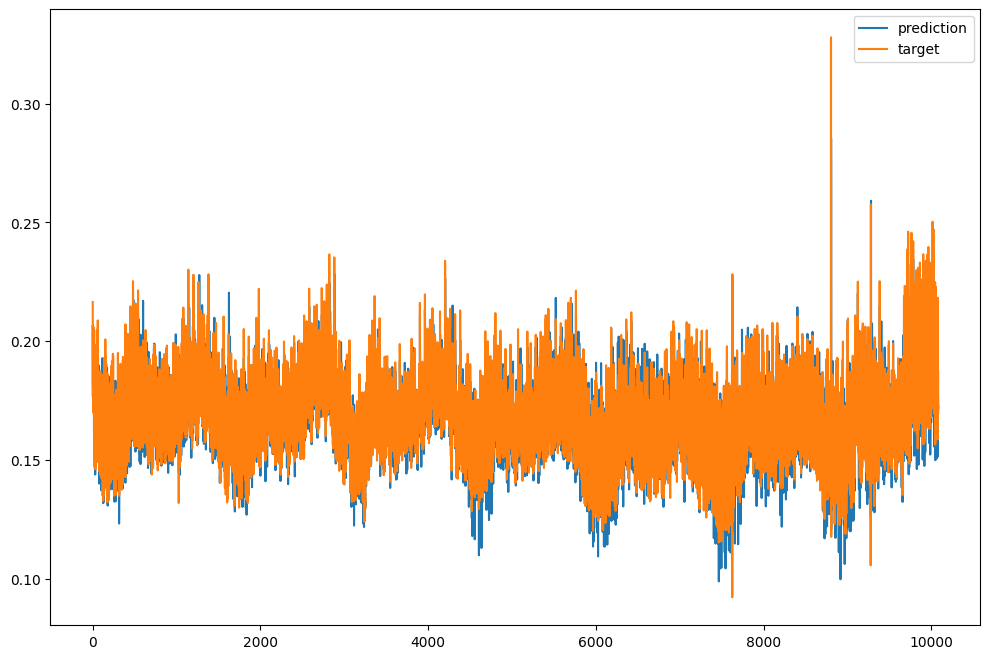

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.17707351, 0.20669241, 0.19666083, ..., 0.18749371, 0.17151155,
       0.17238887])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 3.7786416709423065 %
RMSE 0.009008736349642277
MAPE 3.790648654103279 %


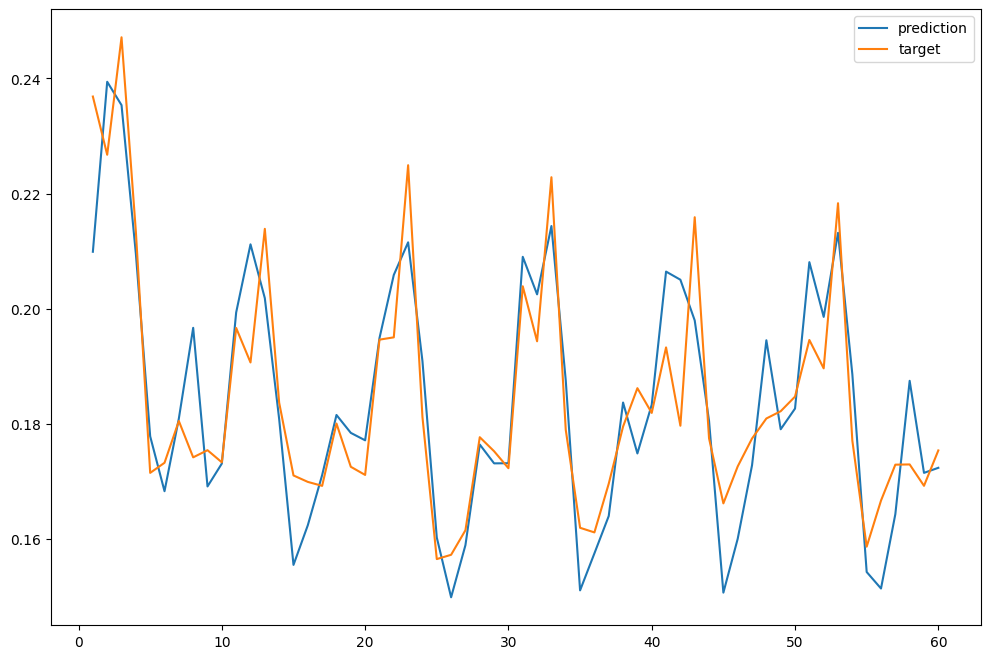

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.40801089987868355